In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import autokeras as ak
from dti_util import tile2im, decode_dam, get_score_importances
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


In [2]:
#datadir = '/Data/sim/antonk/shom5km_defor_4cnn'
rootdir = '/mnt/sfe-ns9602k/Julien/data'
datadir = os.path.join(rootdir,'anton/shom5km_defor_4cnn')
traindir = os.path.join(rootdir,'train')

In [3]:
epsi=1e-2
colnames = ('deformation_0',)
othernames = ('h',)


# Thresholds
th_sit = 0.9 # Sea ice concentration
th_dam = 0.8 # Damage

In [4]:
norm = lambda x : code_dam(x,epsi=epsi, vmin=th_dam)
denorm = lambda x : decode_dam(x,epsi=epsi, vmin=th_dam)

In [5]:
data = np.load(os.path.join(traindir,'train.npz'))

In [6]:
X = data['Xtrain']
y = data['ytrain']
mask_train = data['mask_train']
shape_original = data['shape_original']
print (X.shape[0],mask_train.shape[0])

105957 186960


In [7]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y,
                                                    test_size = 0.15,
                                                    random_state = 1)

In [8]:
input_node = ak.ImageInput()
out_node = ak.Normalization()(input_node)
out_node = ak.ConvBlock()(out_node)
#out_node2 = ak.XceptionBlock()(out_node)
#out_node3 = ak.ResNetBlock()(out_node)
#out_node = ak.Merge()([out_node1, out_node2, out_node3])
output_node = ak.RegressionHead()(out_node)


output_node = ak.RegressionHead()(out_node)
reg_demo = ak.AutoModel(
    inputs=input_node, outputs=output_node, 
    overwrite=True, 
    max_trials=3,
    project_name = 'reg_demo'
)

In [9]:
pretrained = True

if pretrained:
    model = load_model('reg2/model_autokeras')

else:
    reg_demo.fit(
        Xtrain,
        ytrain,
        validation_data=(Xval, yval),
        epochs = 10)
    model = reg_demo.export_model()

In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 1)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 25, 25, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 25, 25, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 23, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14112)            

In [11]:
model.compile(loss='mse')

In [12]:
model.evaluate(Xval, yval, batch_size=20)


795/795 [==============================] - 1s 1ms/step - loss: 0.1040


0.1039634644985199

In [13]:
ypredict = denorm(model.predict(Xval))

In [14]:
import seaborn as sns

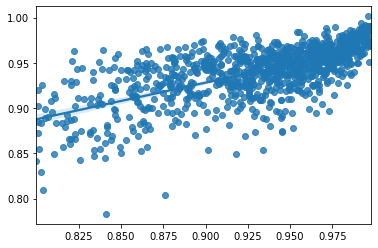

In [15]:
sns.regplot(denorm(yval[:1000]),ypredict[:1000])

In [16]:
yreg = np.clip(1.01 - 0.008/(10**Xval[:,12,12,:1])**0.3,0,1)



In [17]:
rmse_reg = np.sqrt(np.mean(np.square(denorm(yval[~np.isnan(yval)]) - yreg[~np.isnan(yval)])))
rmse_pred = np.sqrt(np.mean(np.square(denorm(yval[~np.isnan(yval)]) - ypredict[~np.isnan(yval)])))
print(f'RMSE Reg: {rmse_reg}\nRMSE NN: {rmse_pred}')

RMSE Reg: 0.06877948144672473
RMSE NN: 0.057524153162253414


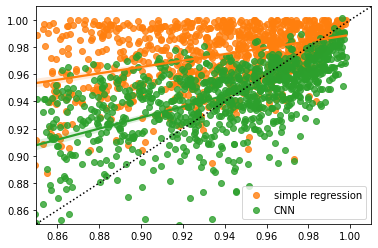

In [18]:
fig, ax = plt.subplots()

sns.regplot(denorm(yval[:1000]),yreg[:1000],color='C1',ax=ax, label="simple regression")
sns.regplot(denorm(yval[:1000]),ypredict[:1000],color='C2',ax=ax, label="CNN")
ax.set_xlim((.85,1.01))
ax.set_ylim((.85,1.01))
ax.plot((.85,1.01),(.85,1.01),':k')
ax.legend()

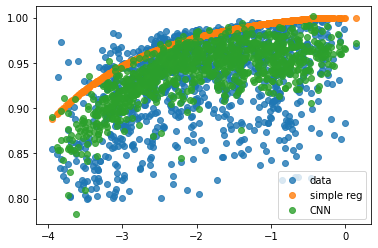

In [19]:
sns.regplot(Xval[:1000,12,12],denorm(yval[:1000]),fit_reg=False, label='data')
sns.regplot(Xval[:1000,12,12],yreg[:1000],fit_reg=False, label= 'simple reg')
sns.regplot(Xval[:1000,12,12],ypredict[:1000],fit_reg=False, label = 'CNN')
plt.legend()

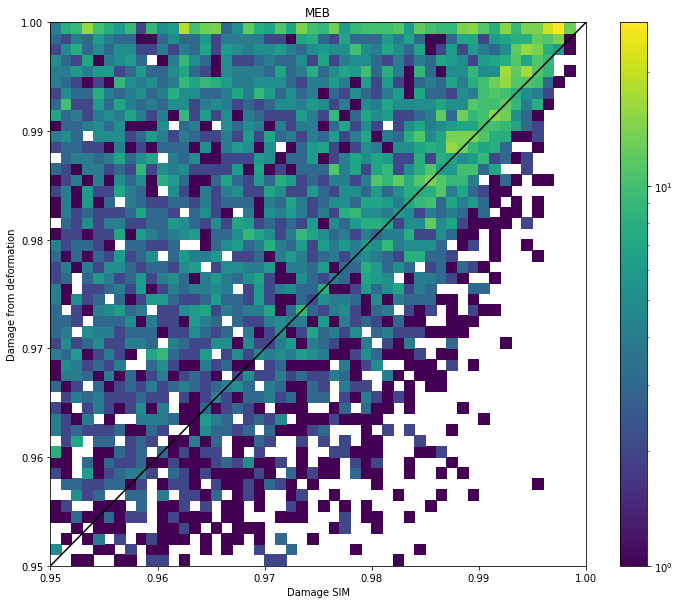

In [20]:
lims = [0.95, 1]
plt.figure(figsize=(12,10))
plt.hist2d(denorm(yval.ravel()),yreg.ravel(),  50, [lims, lims], norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.plot(lims, lims, 'k-')
plt.ylabel('Damage from deformation')
plt.xlabel('Damage SIM')
plt.title('MEB')
plt.show()

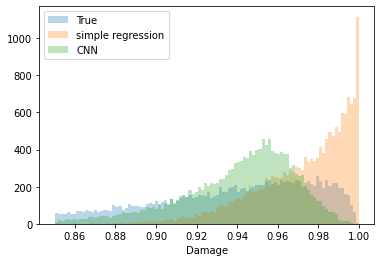

In [21]:
bins = 100

dd = denorm(yval.ravel())
lims = [.85, 1]

plt.hist(dd, bins,  lims, alpha=0.3, label='True')
plt.hist(yreg.ravel(), bins,  lims, alpha=0.3, label='simple regression')
plt.hist(ypredict.ravel(), bins,  lims, alpha=0.3, label='CNN')

plt.xlabel('Damage')
plt.legend()

In [22]:
#from eli5.permutation_importance import get_score_importances


n, nim1, nim2, nc = Xval[:500].shape
X_sk = Xval[:500].reshape((n,-1)) 
y_sk = denorm(yval[:500])
def score_nn (X, y):
    Xtmp = X.reshape((n,nim1,nim2,nc))
    ypredict = denorm(model.predict(Xtmp))
    return np.sqrt(np.mean(np.square(y[~np.isnan(y)] - ypredict[~np.isnan(y)])))
#score_nn(X_sk,denorm(yval))
base_score, score_decreases = get_score_importances(score_nn, 
                                                    X_sk, 
                                                    y_sk, 
                                                    n_iter=3, 
                                                    pre_shuffle=True
                                                   )

preshuffle
preshuffle
preshuffle


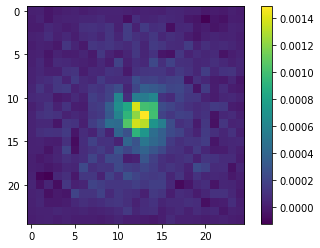

In [25]:
scores_2d = np.mean(score_decreases, axis=0).reshape(nim1,nim2,nc)
plt.imshow(scores_2d[...,0])
plt.colorbar()

In [45]:
data_test = np.load(os.path.join(traindir,'test.npz'))

In [46]:
Xtest = data_test['Xtrain']
ytest = denorm(data_test['ytrain'])
mask_test = data_test['mask_train']
shape_original = data_test['shape_original']
print (Xtest.shape,mask_train.shape[0], shape_original)

(154300, 25, 25, 1) 186960 [  1 400 500]


In [47]:
def tile2im(X1,y1,slic=1,ny=400,nx=500):
    dsize = X1.shape[1]
    nrows = (ny-dsize)//slic + 1
    ncols = (nx-dsize)//slic +1
    nn = X1.shape[0]//(nrows*ncols)
    nc = X1.shape[-1]
    X2 = np.empty((nn,ny,nx,nc))
    y2 = np.zeros((nn,ny,nx,1))
    print(nn,nrows,ncols)
    k=0
    for im in range(nn):
        for ix in range(ncols):
            for iy in range(nrows):
                X2[im,iy*slic:iy*slic+dsize,ix*slic:ix*slic+dsize,:]=X1[k,:,:,:]
                y2[im,iy*slic+dsize//2,ix*slic+dsize//2,:]=y1[k,:]
                k=k+1
    return X2, y2

In [48]:
nn = mask_test.shape[0]
ny = shape_original[1]
nx = shape_original[2]
nc = Xtest.shape[-1]
ntile = Xtest.shape[1]
print(nn,ny,nx,nc)
X1 = np.nan * np.ones((nn,ntile,ntile,nc))
y1 = np.nan * np.ones((nn,1))
y1_predict = np.nan * np.ones((nn,1))
y1_reg = np.nan * np.ones((nn,1))
print(ytest.shape)


178976 400 500 1
(154300,)


In [49]:
X1[mask_test]=Xtest
y1[mask_test,0]=ytest
y1_reg[mask_test,0]=1.01 - 0.008/(10**Xtest[:,12,12,0])**0.3
y1_predict[mask_test] = denorm(model.predict(Xtest))

In [53]:
X2_test, y2_test, = tile2im(X1,y1, slic= 1, ny=shape_original[1], nx=shape_original[2])
X2_predict, y2_reg = tile2im(X1,y1_reg, slic= 1, ny=shape_original[1], nx=shape_original[2])
X2_predict, y2_predict = tile2im(X1,y1_predict, slic= 1, ny=shape_original[1], nx=shape_original[2])

1 376 476
1 376 476
1 376 476


In [54]:
yytest = y2_test[0,...,0]
#yytest[yytest<.85]=np.nan

yyreg = y2_reg[0,...,0]
yyreg[np.isnan(yytest)]=np.nan

yypred = y2_predict[0,...,0]
yypred[np.isnan(yytest)]=np.nan


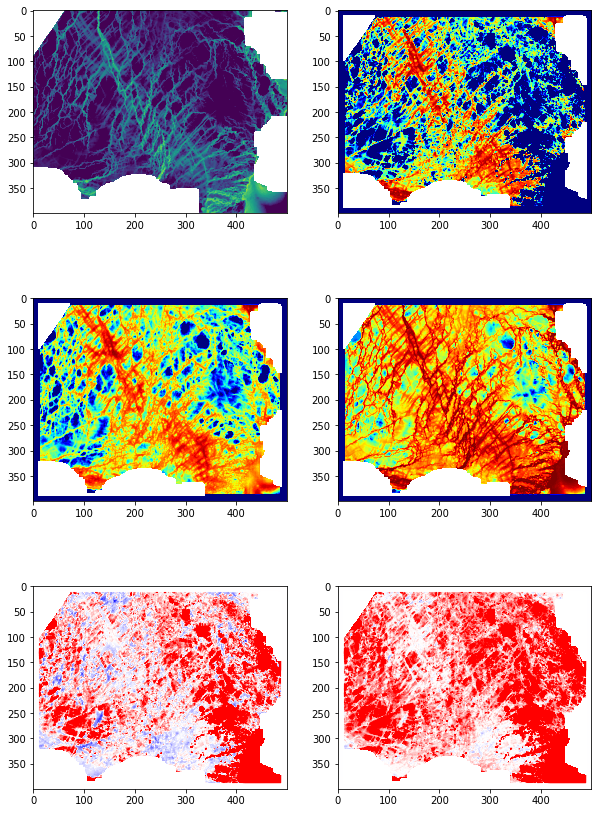

In [58]:
fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(10,15))
ax[0,0].imshow(X2_test[0,...,0],vmin=-3,vmax=1)
ax[0,1].imshow(yytest,vmin=0.85, vmax=1,cmap='jet')
ax[1,0].imshow(yypred,vmin=0.85, vmax=1,cmap='jet')
ax[1,1].imshow(yyreg,vmin=0.85, vmax=1,cmap='jet')
ax[2,0].imshow(yypred-yytest,vmin=-0.1,vmax=0.1,cmap=plt.get_cmap('bwr'))
ax[2,1].imshow(yyreg-yytest,vmin=-0.1,vmax=0.1,cmap=plt.get_cmap('bwr'))

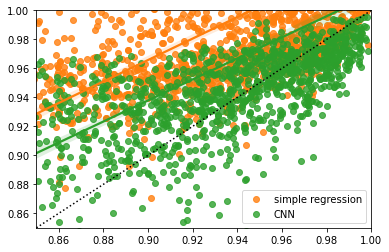

In [59]:
fig, ax = plt.subplots()
sns.regplot(yytest[~np.isnan(yytest)][::100],yyreg[~np.isnan(yytest)][::100],ax=ax,color='C1',label="simple regression")
sns.regplot(yytest[~np.isnan(yytest)][::100],yypred[~np.isnan(yytest)][::100],ax=ax,color='C2',label='CNN')
ax.set_xlim((.85,1))
ax.set_ylim((.85,1))
ax.plot((.85,1.01),(.85,1.01),':k')
ax.legend()

In [31]:
rmse_reg = np.sqrt(np.mean(np.square(yytest[~np.isnan(yytest)] - yyreg[~np.isnan(yytest)])))
rmse_pred = np.sqrt(np.mean(np.square(yytest[~np.isnan(yytest)] - yypred[~np.isnan(yytest)])))
print(f'RMSE Reg: {rmse_reg}\nRMSE NN: {rmse_pred}')

RMSE Reg: 0.03970481149783264
RMSE NN: 0.032035232297956434


In [32]:
corr_reg = np.corrcoef(yytest[~np.isnan(yytest)],yyreg[~np.isnan(yytest)])[0,1]
corr_pred = np.corrcoef(yytest[~np.isnan(yytest)],yypred[~np.isnan(yytest)])[0,1]
print(f'corr Reg: {corr_reg}\ncorr NN: {corr_pred}')

corr Reg: 0.6122691899963838
corr NN: 0.5951387045332852


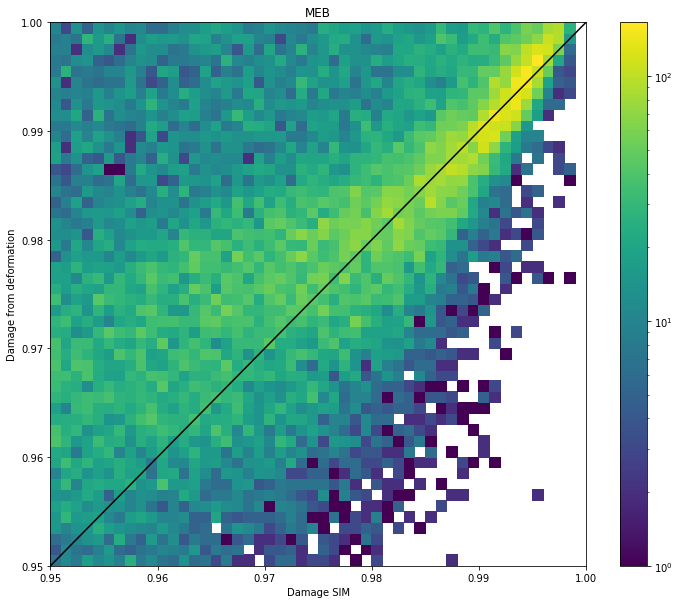

In [65]:
lims = [0.95, 1]
plt.figure(figsize=(12,10))
plt.hist2d(yytest.ravel(),yyreg.ravel(),  50, [lims, lims], norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.plot(lims, lims, 'k-')
plt.ylabel('Damage from deformation')
plt.xlabel('Damage SIM')
plt.title('MEB')
plt.show()

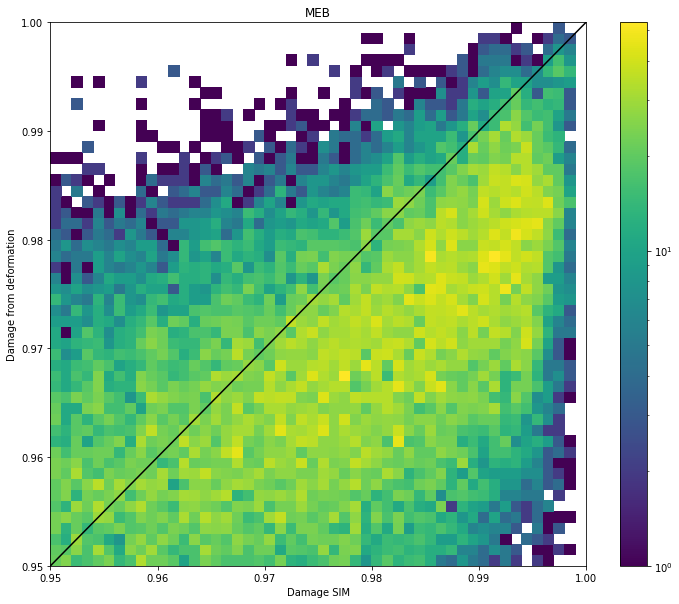

In [66]:
lims = [0.95, 1]
plt.figure(figsize=(12,10))
plt.hist2d(yytest.ravel(),yypred.ravel(),  50, [lims, lims], norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.plot(lims, lims, 'k-')
plt.ylabel('Damage from deformation')
plt.xlabel('Damage SIM')
plt.title('MEB')
plt.show()

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 106 kB 3.0 MB/s eta 0:00:01
